In [114]:
"""
CRVFT MVP: Cross-Stitch Pattern Generator with 5 Parameters
Research System for Learning Aesthetic Preferences

Parameters:
1. num_colors: Number of distinct colors (6, 10, 15, 20, 25)
2. contrast: Contrast adjustment (0.5 - 2.0)
3. posterization: Flatten to graphic regions (0.0 - 1.0)
4. dithering_strength: Dithering vs solid colors (0.0 - 1.0)
5. edge_outline: Add dark outlines (0.0 - 1.0)
"""



'\nCRVFT MVP: Cross-Stitch Pattern Generator with 5 Parameters\nResearch System for Learning Aesthetic Preferences\n\nParameters:\n1. num_colors: Number of distinct colors (6, 10, 15, 20, 25)\n2. contrast: Contrast adjustment (0.5 - 2.0)\n3. posterization: Flatten to graphic regions (0.0 - 1.0)\n4. dithering_strength: Dithering vs solid colors (0.0 - 1.0)\n5. edge_outline: Add dark outlines (0.0 - 1.0)\n'

In [115]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance
from sklearn.cluster import KMeans
from scipy import ndimage
import json
from pathlib import Path
import itertools


In [116]:

# ============================================================================
# DMC COLOR DATABASE (simplified - 20 common colors to start)
# ============================================================================

DMC_COLORS = {
    'blanc': {'name': 'White', 'rgb': [255, 255, 255]},
    'ecru': {'name': 'Ecru', 'rgb': [240, 234, 218]},
    '310': {'name': 'Black', 'rgb': [0, 0, 0]},
    '321': {'name': 'Red', 'rgb': [199, 44, 65]},
    '666': {'name': 'Bright Red', 'rgb': [227, 37, 37]},
    '741': {'name': 'Tangerine', 'rgb': [255, 163, 43]},
    '743': {'name': 'Yellow', 'rgb': [254, 230, 110]},
    '444': {'name': 'Dark Yellow', 'rgb': [255, 201, 0]},
    '906': {'name': 'Parrot Green', 'rgb': [137, 194, 38]},
    '700': {'name': 'Bright Green', 'rgb': [0, 123, 40]},
    '699': {'name': 'Christmas Green', 'rgb': [0, 91, 6]},
    '825': {'name': 'Dark Blue', 'rgb': [55, 101, 155]},
    '3843': {'name': 'Electric Blue', 'rgb': [20, 170, 208]},
    '996': {'name': 'Electric Blue Med', 'rgb': [51, 181, 229]},
    '333': {'name': 'Blue Violet Dark', 'rgb': [92, 84, 125]},
    '552': {'name': 'Violet Medium', 'rgb': [128, 71, 133]},
    '718': {'name': 'Plum', 'rgb': [217, 89, 142]},
    '945': {'name': 'Peach', 'rgb': [250, 202, 171]},
    '3371': {'name': 'Black Brown', 'rgb': [66, 43, 33]},
    '762': {'name': 'Pearl Gray', 'rgb': [236, 236, 236]},
}

# Convert to list for easier processing
DMC_LIST = [(code, data['name'], np.array(data['rgb'])) 
            for code, data in DMC_COLORS.items()]

# ============================================================================
# HELPER FUNCTIONS
# ============================================================================


In [117]:

def load_and_resize(image_path, grid_size=50):
    """Load image and resize to grid dimensions"""
    img = Image.open(image_path).convert('RGB')
    img = img.resize((grid_size, grid_size), Image.Resampling.LANCZOS)
    return np.array(img)


In [118]:

def apply_contrast(image, contrast_factor):
    """Adjust image contrast"""
    if contrast_factor == 1.0:
        return image
    
    img_pil = Image.fromarray(image)
    enhancer = ImageEnhance.Contrast(img_pil)
    result = enhancer.enhance(contrast_factor)
    return np.array(result)


In [119]:

def apply_posterization(image, posterize_strength):
    """Reduce to flat color regions"""
    if posterize_strength == 0:
        return image
    
    # Reduce bit depth to create posterization effect
    # More strength = fewer levels
    levels = int(8 - 6 * posterize_strength)  # 8 bits down to 2 bits
    levels = max(2, levels)
    
    # Quantize each channel
    factor = 256 / (2 ** levels)
    posterized = (image / factor).astype(int) * factor
    return np.clip(posterized, 0, 255).astype(np.uint8)


In [120]:

def quantize_colors_kmeans(image, num_colors):
    """Reduce to N colors using K-means clustering"""
    h, w, c = image.shape
    pixels = image.reshape(-1, 3)
    
    # K-means clustering
    kmeans = KMeans(n_clusters=num_colors, random_state=42, n_init=10)
    kmeans.fit(pixels)
    
    # Get palette and labels
    palette = kmeans.cluster_centers_.astype(np.uint8)
    labels = kmeans.labels_.reshape(h, w)
    
    # Create quantized image
    quantized = palette[labels]
    
    return quantized, palette, labels


In [121]:

def floyd_steinberg_dither(image, palette, labels):
    """Apply Floyd-Steinberg dithering"""
    h, w, c = image.shape
    dithered = image.astype(float).copy()
    output_labels = labels.copy()
    
    for y in range(h):
        for x in range(w):
            old_pixel = dithered[y, x]
            
            # Find nearest color in palette
            distances = np.sum((palette - old_pixel) ** 2, axis=1)
            new_idx = np.argmin(distances)
            new_pixel = palette[new_idx]
            
            output_labels[y, x] = new_idx
            dithered[y, x] = new_pixel
            
            # Calculate and distribute error
            error = old_pixel - new_pixel
            
            if x + 1 < w:
                dithered[y, x + 1] += error * 7/16
            if y + 1 < h:
                if x > 0:
                    dithered[y + 1, x - 1] += error * 3/16
                dithered[y + 1, x] += error * 5/16
                if x + 1 < w:
                    dithered[y + 1, x + 1] += error * 1/16
    
    return np.clip(dithered, 0, 255).astype(np.uint8), output_labels


In [122]:

def apply_dithering(quantized, palette, labels, dithering_strength):
    """Blend between solid colors and dithered version"""
    if dithering_strength == 0:
        return quantized, labels
    
    dithered, dithered_labels = floyd_steinberg_dither(quantized, palette, labels)
    
    if dithering_strength < 1.0:
        # Blend between non-dithered and dithered
        blended = (quantized * (1 - dithering_strength) + 
                   dithered * dithering_strength).astype(np.uint8)
        return blended, labels
    
    return dithered, dithered_labels


In [123]:

def detect_edges(image):
    """Detect edges using Sobel filter"""
    gray = np.mean(image, axis=2)
    
    # Sobel edge detection
    sx = ndimage.sobel(gray, axis=0)
    sy = ndimage.sobel(gray, axis=1)
    edges = np.hypot(sx, sy)
    
    # Normalize to 0-1
    edges = edges / edges.max() if edges.max() > 0 else edges
    
    return edges


In [124]:

def apply_edge_outline(pattern_labels, palette, edges, outline_strength):
    """Add dark outlines around edges"""
    if outline_strength == 0:
        return pattern_labels
    
    # Find darkest color in palette
    darkness = np.sum(palette, axis=1)
    darkest_idx = np.argmin(darkness)
    
    # Threshold edges based on outline strength
    threshold = 1.0 - outline_strength
    strong_edges = edges > (threshold * 0.3)  # Adjusted for visibility
    
    # Apply outlines
    outlined = pattern_labels.copy()
    outlined[strong_edges] = darkest_idx
    
    return outlined


In [125]:

def map_to_dmc(palette):
    """Map RGB palette to nearest DMC colors"""
    dmc_mapping = []
    
    for color in palette:
        # Find nearest DMC color using Euclidean distance
        distances = [np.sum((color - dmc_rgb) ** 2) 
                     for _, _, dmc_rgb in DMC_LIST]
        nearest_idx = np.argmin(distances)
        dmc_code, dmc_name, dmc_rgb = DMC_LIST[nearest_idx]
        
        dmc_mapping.append({
            'code': dmc_code,
            'name': dmc_name,
            'rgb': dmc_rgb.tolist(),
            'original_rgb': color.tolist()
        })
    
    return dmc_mapping


In [126]:

# ============================================================================
# MAIN PATTERN GENERATION FUNCTION
# ============================================================================

def generate_pattern(image_path, params, grid_size=50):
    """
    Generate cross-stitch pattern with 5 parameters
    
    Parameters:
    -----------
    image_path : str
        Path to source image
    params : dict
        {
            'num_colors': int (6, 10, 15, 20, 25),
            'contrast': float (0.5 - 2.0),
            'posterization': float (0.0 - 1.0),
            'dithering_strength': float (0.0 - 1.0),
            'edge_outline': float (0.0 - 1.0)
        }
    grid_size : int
        Size of pattern grid (default 50x50)
    
    Returns:
    --------
    dict with pattern data
    """
    
    # 1. Load and resize
    img = load_and_resize(image_path, grid_size)
    
    # 2. Apply contrast
    img = apply_contrast(img, params['contrast'])
    
    # 3. Apply posterization
    img = apply_posterization(img, params['posterization'])
    
    # 4. Detect edges (before quantization for better detection)
    edges = detect_edges(img)
    
    # 5. Quantize colors
    quantized, palette, labels = quantize_colors_kmeans(img, params['num_colors'])
    
    # 6. Apply dithering
    dithered, dithered_labels = apply_dithering(
        quantized, palette, labels, params['dithering_strength']
    )
    
    # 7. Apply edge outlines
    final_labels = apply_edge_outline(
        dithered_labels, palette, edges, params['edge_outline']
    )
    
    # 8. Map to DMC colors
    dmc_palette = map_to_dmc(palette)
    
    # 9. Create final pattern with DMC colors
    h, w = final_labels.shape
    final_pattern = np.zeros((h, w, 3), dtype=np.uint8)
    for i in range(len(palette)):
        mask = final_labels == i
        final_pattern[mask] = palette[i]
    
    # 10. Calculate metadata
    unique_colors = len(np.unique(final_labels))
    stitch_count = grid_size * grid_size
    
    # Count color changes (rough estimate)
    color_changes = 0
    for y in range(h):
        for x in range(w-1):
            if final_labels[y, x] != final_labels[y, x+1]:
                color_changes += 1
    
    return {
        'pattern': final_pattern,
        'pattern_labels': final_labels,
        'palette': dmc_palette,
        'params': params,
        'metadata': {
            'stitch_count': stitch_count,
            'unique_colors': unique_colors,
            'color_changes': color_changes,
            'source_image': str(image_path),
            'grid_size': grid_size
        }
    }


In [127]:
def visualize_pattern(result, show_grid=False, upscale_factor=10):
    """Visualize the generated pattern with upscaling for better display"""
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    
    # Upscale pattern for display (nearest neighbor to keep blocky/pixelated look)
    pattern = result['pattern']
    h, w = pattern.shape[:2]
    upscaled = np.repeat(np.repeat(pattern, upscale_factor, axis=0), upscale_factor, axis=1)
    
    # Original pattern (upscaled)
    axes[0].imshow(upscaled, interpolation='nearest')
    axes[0].set_title(f'Generated Pattern ({h}×{w} stitches)', fontsize=14)
    axes[0].axis('off')
    
    # Pattern with grid
    if show_grid:
        axes[1].imshow(upscaled, interpolation='nearest')
        h_scaled = h * upscale_factor
        w_scaled = w * upscale_factor
        # Add grid lines every N stitches (shows 10-stitch grid)
        grid_spacing = upscale_factor * 10
        for i in range(0, h_scaled, grid_spacing):
            axes[1].axhline(i, color='black', linewidth=1.5, alpha=0.7)
        for j in range(0, w_scaled, grid_spacing):
            axes[1].axvline(j, color='black', linewidth=1.5, alpha=0.7)
        # Add minor grid lines every stitch
        for i in range(0, h_scaled, upscale_factor):
            axes[1].axhline(i, color='gray', linewidth=0.3, alpha=0.3)
        for j in range(0, w_scaled, upscale_factor):
            axes[1].axvline(j, color='gray', linewidth=0.3, alpha=0.3)
        axes[1].set_title('Pattern with Stitch Grid', fontsize=14)
        axes[1].axis('off')
    else:
        # Show palette (larger)
        palette_img = np.array([d['rgb'] for d in result['palette']]).reshape(1, -1, 3)
        palette_upscaled = np.repeat(palette_img, 50, axis=0)  # Make palette taller
        axes[1].imshow(palette_upscaled, aspect='auto', interpolation='nearest')
        axes[1].set_title(f"DMC Palette ({len(result['palette'])} colors)", fontsize=14)
        axes[1].axis('off')
        
        # Add DMC codes as text
        for idx, color_info in enumerate(result['palette']):
            axes[1].text(idx + 0.5, 25, color_info['code'], 
                        ha='center', va='center', fontsize=10, 
                        color='white' if sum(color_info['rgb']) < 384 else 'black',
                        weight='bold')
    
    # Add parameter info
    params_text = '\n'.join([f"{k}: {v}" for k, v in result['params'].items()])
    meta_text = f"\nStitches: {result['metadata']['stitch_count']}\n"
    meta_text += f"Colors: {result['metadata']['unique_colors']}\n"
    meta_text += f"Changes: {result['metadata']['color_changes']}"
    
    plt.figtext(0.5, 0.02, params_text + meta_text, 
                ha='center', fontsize=9, family='monospace')
    
    plt.tight_layout()
    return fig

def compare_parameters(image_path, param_variations, grid_size=50, upscale_factor=8):
    """Compare different parameter settings side by side"""
    results = []
    for params in param_variations:
        result = generate_pattern(image_path, params, grid_size)
        results.append(result)
    
    n = len(results)
    cols = min(3, n)
    rows = (n + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 6*rows))
    if n == 1:
        axes = [axes]
    else:
        axes = axes.flatten()
    
    for idx, result in enumerate(results):
        # Upscale for display
        pattern = result['pattern']
        upscaled = np.repeat(np.repeat(pattern, upscale_factor, axis=0), upscale_factor, axis=1)
        axes[idx].imshow(upscaled, interpolation='nearest')
        
        # Create concise title from key params
        param_str = f"C:{result['params']['num_colors']} "
        param_str += f"Cont:{result['params']['contrast']:.1f} "
        param_str += f"Post:{result['params']['posterization']:.1f}\n"
        param_str += f"Dith:{result['params']['dithering_strength']:.1f} "
        param_str += f"Edge:{result['params']['edge_outline']:.1f}"
        axes[idx].set_title(param_str, fontsize=9)
        axes[idx].axis('off')
    
    # Hide unused subplots
    for idx in range(n, len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    return fig

In [128]:

# ============================================================================
# BATCH GENERATION FOR RESEARCH
# ============================================================================

def generate_parameter_samples(n_samples=100, strategy='random'):
    """Generate parameter configurations for research"""
    
    if strategy == 'grid':
        # Grid search over key values
        num_colors = [6, 10, 15, 20]
        contrast = [0.7, 1.0, 1.3]
        posterization = [0.0, 0.5, 1.0]
        dithering = [0.0, 0.5, 1.0]
        edge_outline = [0.0, 0.5]
        
        configs = []
        for combo in itertools.product(num_colors, contrast, posterization, 
                                       dithering, edge_outline):
            configs.append({
                'num_colors': combo[0],
                'contrast': combo[1],
                'posterization': combo[2],
                'dithering_strength': combo[3],
                'edge_outline': combo[4]
            })
        return configs[:n_samples]
    
    elif strategy == 'random':
        # Random sampling
        configs = []
        for _ in range(n_samples):
            configs.append({
                'num_colors': int(np.random.choice([6, 10, 15, 20, 25])),
                'contrast': np.random.uniform(0.5, 2.0),
                'posterization': np.random.uniform(0.0, 1.0),
                'dithering_strength': np.random.uniform(0.0, 1.0),
                'edge_outline': np.random.uniform(0.0, 1.0)
            })
        return configs
    
    elif strategy == 'extremes':
        # Test extreme combinations
        configs = [
            # All minimum
            {'num_colors': 6, 'contrast': 0.5, 'posterization': 0.0, 
             'dithering_strength': 0.0, 'edge_outline': 0.0},
            # All maximum
            {'num_colors': 25, 'contrast': 2.0, 'posterization': 1.0, 
             'dithering_strength': 1.0, 'edge_outline': 1.0},
            # High detail
            {'num_colors': 25, 'contrast': 1.2, 'posterization': 0.0, 
             'dithering_strength': 0.8, 'edge_outline': 0.0},
            # Graphic style
            {'num_colors': 10, 'contrast': 1.5, 'posterization': 0.8, 
             'dithering_strength': 0.0, 'edge_outline': 0.7},
            # Balanced
            {'num_colors': 15, 'contrast': 1.0, 'posterization': 0.3, 
             'dithering_strength': 0.5, 'edge_outline': 0.2},
        ]
        return configs

def batch_generate(image_paths, param_configs, output_dir, grid_size=50):
    """Generate patterns for all images and configurations"""
    output_dir = Path(output_dir)
    output_dir.mkdir(exist_ok=True, parents=True)
    
    results = []
    
    for img_idx, img_path in enumerate(image_paths):
        img_name = Path(img_path).stem
        
        for param_idx, params in enumerate(param_configs):
            print(f"Processing {img_name} with config {param_idx+1}/{len(param_configs)}")
            
            result = generate_pattern(img_path, params, grid_size)
            
            # Save pattern
            pattern_id = f"{img_name}_config{param_idx:03d}"
            pattern_path = output_dir / f"{pattern_id}.png"
            Image.fromarray(result['pattern']).save(pattern_path)
            
            # Save metadata
            meta_path = output_dir / f"{pattern_id}_meta.json"
            with open(meta_path, 'w') as f:
                json.dump({
                    'pattern_id': pattern_id,
                    'params': result['params'],
                    'metadata': result['metadata'],
                    'palette': result['palette']
                }, f, indent=2)
            
            results.append({
                'pattern_id': pattern_id,
                'image': img_name,
                'params': params,
                'pattern_path': str(pattern_path)
            })
    
    # Save manifest
    manifest_path = output_dir / 'manifest.json'
    with open(manifest_path, 'w') as f:
        json.dump(results, f, indent=2)
    
    print(f"\nGenerated {len(results)} patterns in {output_dir}")
    return results


In [129]:

# ============================================================================
# MULTI-DIMENSIONAL COMPARISON FUNCTIONS
# ============================================================================

def compare_grid_sizes(image_path, params, grid_sizes=[50, 80, 120], upscale_to=400):
    """Compare same parameters at different grid sizes"""
    fig, axes = plt.subplots(1, len(grid_sizes), figsize=(6*len(grid_sizes), 6))
    if len(grid_sizes) == 1:
        axes = [axes]
    
    for idx, size in enumerate(grid_sizes):
        result = generate_pattern(image_path, params, grid_size=size)
        
        # Upscale all to same display size for fair comparison
        upscale_factor = upscale_to // size
        upscaled = np.repeat(np.repeat(result['pattern'], upscale_factor, axis=0), 
                            upscale_factor, axis=1)
        
        axes[idx].imshow(upscaled, interpolation='nearest')
        axes[idx].set_title(f'{size}×{size} stitches\n({result["metadata"]["unique_colors"]} colors used)', 
                          fontsize=12)
        axes[idx].axis('off')
    
    # Add parameter info at bottom
    params_text = ', '.join([f"{k}: {v}" for k, v in params.items()])
    plt.figtext(0.5, 0.02, params_text, ha='center', fontsize=10, family='monospace')
    
    plt.tight_layout()
    return fig

def compare_grid_and_params(image_path, param_variations, grid_sizes=[50, 80, 120]):
    """
    Create a grid comparing multiple parameters AND grid sizes
    Rows = different parameters
    Cols = different grid sizes
    """
    n_params = len(param_variations)
    n_sizes = len(grid_sizes)
    
    fig, axes = plt.subplots(n_params, n_sizes, figsize=(5*n_sizes, 5*n_params))
    
    # Handle single row/col cases
    if n_params == 1 and n_sizes == 1:
        axes = [[axes]]
    elif n_params == 1:
        axes = [axes]
    elif n_sizes == 1:
        axes = [[ax] for ax in axes]
    
    for param_idx, params in enumerate(param_variations):
        for size_idx, size in enumerate(grid_sizes):
            result = generate_pattern(image_path, params, grid_size=size)
            
            # Upscale for display (all to same pixel size)
            upscale_factor = 400 // size
            upscaled = np.repeat(np.repeat(result['pattern'], upscale_factor, axis=0), 
                                upscale_factor, axis=1)
            
            axes[param_idx][size_idx].imshow(upscaled, interpolation='nearest')
            
            # Title: grid size and key params
            title = f'{size}×{size}\n'
            title += f"C:{params['num_colors']} "
            title += f"Post:{params['posterization']:.1f} "
            title += f"Edge:{params['edge_outline']:.1f}"
            axes[param_idx][size_idx].set_title(title, fontsize=9)
            axes[param_idx][size_idx].axis('off')
    
    plt.tight_layout()
    return fig
def exhaustive_comparison(image_path, grid_sizes=[50, 80, 120], n_param_samples=50):
    """
    Generate a comprehensive comparison with:
    - Multiple grid sizes
    - Many random parameter combinations
    
    Creates n_param_samples × len(grid_sizes) total variations
    """
    
    # Generate random parameter combinations with better constraints
    np.random.seed(42)  # For reproducibility
    param_configs = []
    
    for i in range(n_param_samples):
        # Sample contrast and posterization with constraints to avoid pure black
        contrast = np.random.uniform(0.6, 1.6)  # Narrower range, avoid extremes
        posterization = np.random.uniform(0.0, 0.8)  # Cap posterization
        
        # If both are high, reduce one of them
        if contrast > 1.3 and posterization > 0.6:
            if np.random.random() < 0.5:
                contrast = np.random.uniform(0.8, 1.2)
            else:
                posterization = np.random.uniform(0.0, 0.5)
        
        config = {
            'num_colors': int(np.random.choice([8, 10, 12, 15, 18, 20, 25])),  # Removed 6 (too few)
            'contrast': contrast,
            'posterization': posterization,
            'dithering_strength': np.random.uniform(0.0, 1.0),
            'edge_outline': np.random.uniform(0.0, 0.8),  # Cap outlines too
        }
        param_configs.append(config)
    
    n_params = len(param_configs)
    n_sizes = len(grid_sizes)
    
    # Calculate good subplot layout
    # For 50 configs × 3 sizes = 150 subplots, we need a reasonable grid
    total_variations = n_params * n_sizes
    
    # Arrange as: each row is one parameter config, columns are grid sizes
    fig, axes = plt.subplots(n_params, n_sizes, 
                            figsize=(4*n_sizes, 3*n_params))
    
    # Handle single row/col cases
    if n_params == 1 and n_sizes == 1:
        axes = [[axes]]
    elif n_params == 1:
        axes = [axes]
    elif n_sizes == 1:
        axes = [[ax] for ax in axes]
    
    print(f"Generating {total_variations} pattern variations...")
    print(f"({n_params} parameter configs × {n_sizes} grid sizes)")
    
    for param_idx, params in enumerate(param_configs):
        if param_idx % 10 == 0:
            print(f"Progress: {param_idx}/{n_params} parameter configs...")
        
        for size_idx, size in enumerate(grid_sizes):
            result = generate_pattern(image_path, params, grid_size=size)
            
            # Upscale for display
            upscale_factor = max(1, 300 // size)
            upscaled = np.repeat(np.repeat(result['pattern'], upscale_factor, axis=0), 
                                upscale_factor, axis=1)
            
            axes[param_idx][size_idx].imshow(upscaled, interpolation='nearest')
            
            # Compact title
            title = f"{size}×{size}\n"
            title += f"C{params['num_colors']} "
            title += f"Ct{params['contrast']:.1f} "
            title += f"P{params['posterization']:.1f}\n"
            title += f"D{params['dithering_strength']:.1f} "
            title += f"E{params['edge_outline']:.1f}"
            
            axes[param_idx][size_idx].set_title(title, fontsize=7)
            axes[param_idx][size_idx].axis('off')
    
    plt.suptitle(f'50 Parameter Variations × {n_sizes} Grid Sizes: {Path(image_path).name}', 
                 fontsize=14, weight='bold', y=0.9995)
    plt.tight_layout()
    
    print(f"✓ Generated all {total_variations} variations!")
    return fig

def exhaustive_comparison_compact(image_path, grid_sizes=[50, 80, 120], n_param_samples=50):
    """
    More compact version - shows all variations in a denser grid
    Better for quickly scanning many options
    """
    
    # Generate random parameter combinations with better constraints
    np.random.seed(42)
    param_configs = []
    
    for i in range(n_param_samples):
        # Sample contrast and posterization with constraints to avoid pure black
        contrast = np.random.uniform(0.6, 1.6)  # Narrower range, avoid extremes
        posterization = np.random.uniform(0.0, 0.8)  # Cap posterization
        
        # If both are high, reduce one of them
        if contrast > 1.3 and posterization > 0.6:
            if np.random.random() < 0.5:
                contrast = np.random.uniform(0.8, 1.2)
            else:
                posterization = np.random.uniform(0.0, 0.5)
        
        config = {
            'num_colors': int(np.random.choice([8, 10, 12, 15, 18, 20, 25])),  # Removed 6 (too few)
            'contrast': contrast,
            'posterization': posterization,
            'dithering_strength': np.random.uniform(0.0, 1.0),
            'edge_outline': np.random.uniform(0.0, 0.8),  # Cap outlines too
        }
        param_configs.append(config)
    
    total_variations = n_param_samples * len(grid_sizes)
    
    # Arrange in a square-ish grid
    cols = int(np.ceil(np.sqrt(total_variations)))
    rows = int(np.ceil(total_variations / cols))
    
    fig, axes = plt.subplots(rows, cols, figsize=(2*cols, 2*rows))
    axes = axes.flatten()
    
    print(f"Generating {total_variations} pattern variations in {rows}×{cols} grid...")
    
    idx = 0
    for param_idx, params in enumerate(param_configs):
        if param_idx % 10 == 0:
            print(f"Progress: {idx}/{total_variations} variations...")
        
        for size in grid_sizes:
            result = generate_pattern(image_path, params, grid_size=size)
            
            # Upscale for display
            upscale_factor = max(1, 200 // size)
            upscaled = np.repeat(np.repeat(result['pattern'], upscale_factor, axis=0), 
                                upscale_factor, axis=1)
            
            axes[idx].imshow(upscaled, interpolation='nearest')
            
            # Minimal title - just grid size and config number
            axes[idx].set_title(f"#{param_idx+1} {size}×{size}", fontsize=6)
            axes[idx].axis('off')
            
            idx += 1
    
    # Hide unused subplots
    for i in range(idx, len(axes)):
        axes[i].axis('off')
    
    plt.suptitle(f'{n_param_samples} Random Configs × {len(grid_sizes)} Sizes: {Path(image_path).name}', 
                 fontsize=12, weight='bold')
    plt.tight_layout()
    
    print(f"✓ Generated all {total_variations} variations!")
    return fig, param_configs

In [130]:

# ============================================================================
# EXAMPLE USAGE
# ============================================================================

if __name__ == "__main__":
    print("CRVFT MVP - Cross-Stitch Pattern Generator")
    print("=" * 50)
    
    # Example: Generate a single pattern
    example_params = {
        'num_colors': 15,
        'contrast': 1.2,
        'posterization': 0.3,
        'dithering_strength': 0.5,
        'edge_outline': 0.2
    }
    
    # Replace with your actual image path
    # result = generate_pattern('path/to/your/image.png', example_params)
    # fig = visualize_pattern(result)
    # plt.show()
    
    print("\nTo use this notebook:")
    print("1. Load your 20 images")
    print("2. Generate parameter samples: configs = generate_parameter_samples(100)")
    print("3. Batch generate: batch_generate(image_paths, configs, 'output_dir')")
    print("4. Build preference collection UI")

CRVFT MVP - Cross-Stitch Pattern Generator

To use this notebook:
1. Load your 20 images
2. Generate parameter samples: configs = generate_parameter_samples(100)
3. Batch generate: batch_generate(image_paths, configs, 'output_dir')
4. Build preference collection UI


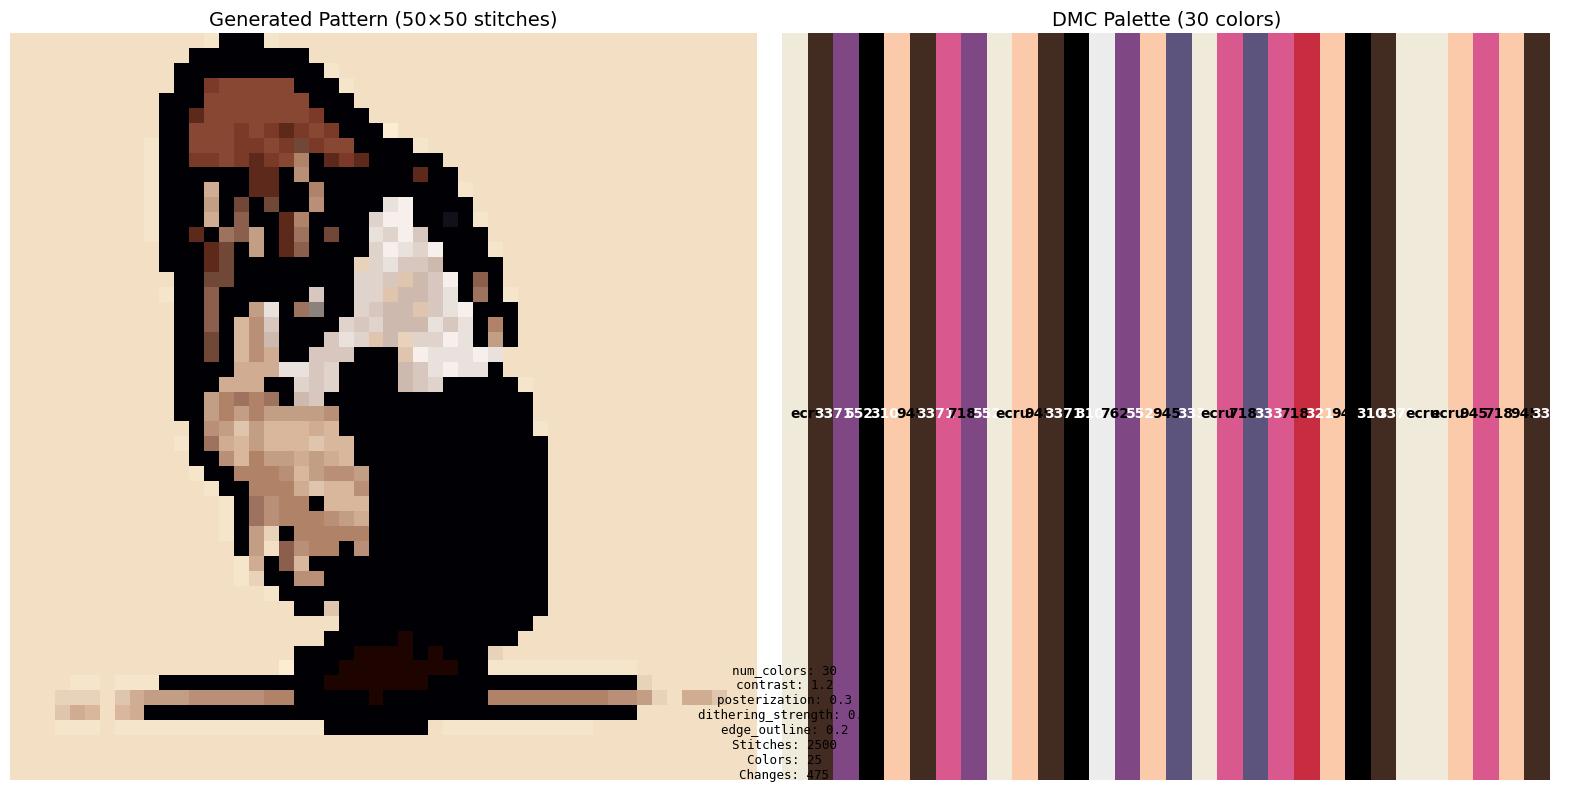

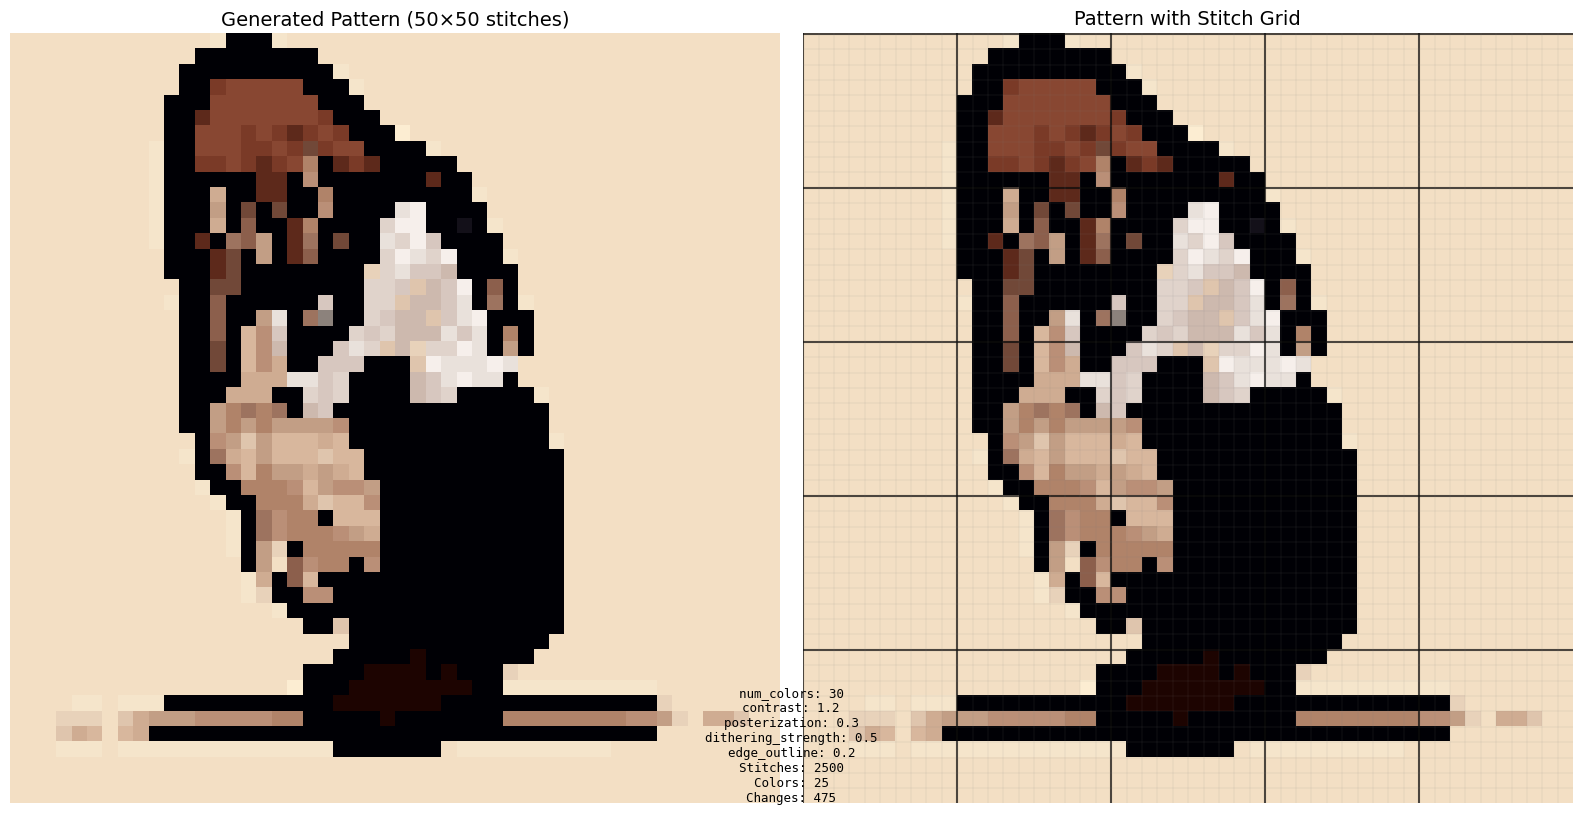

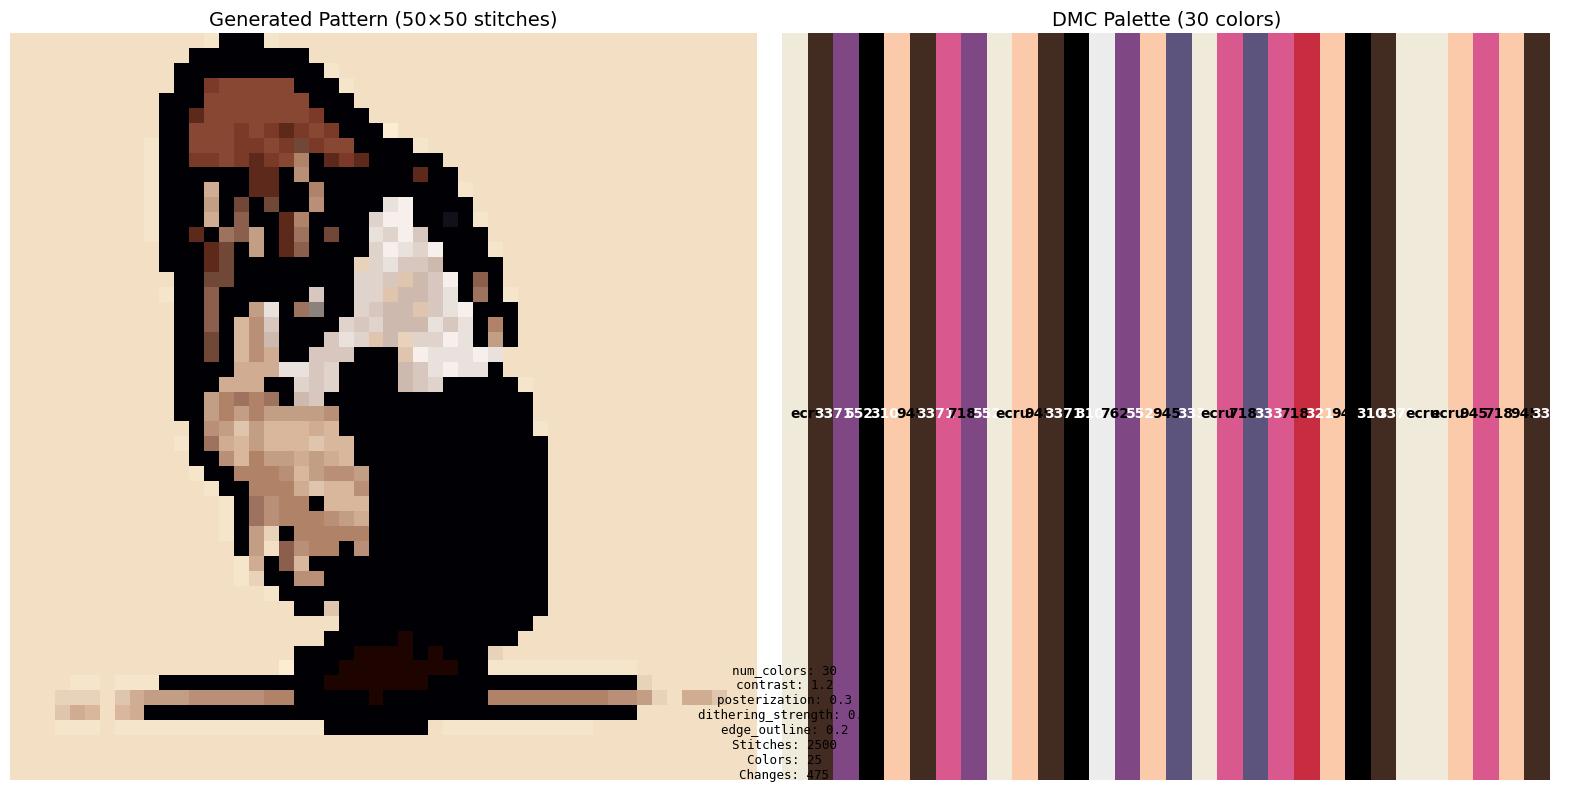

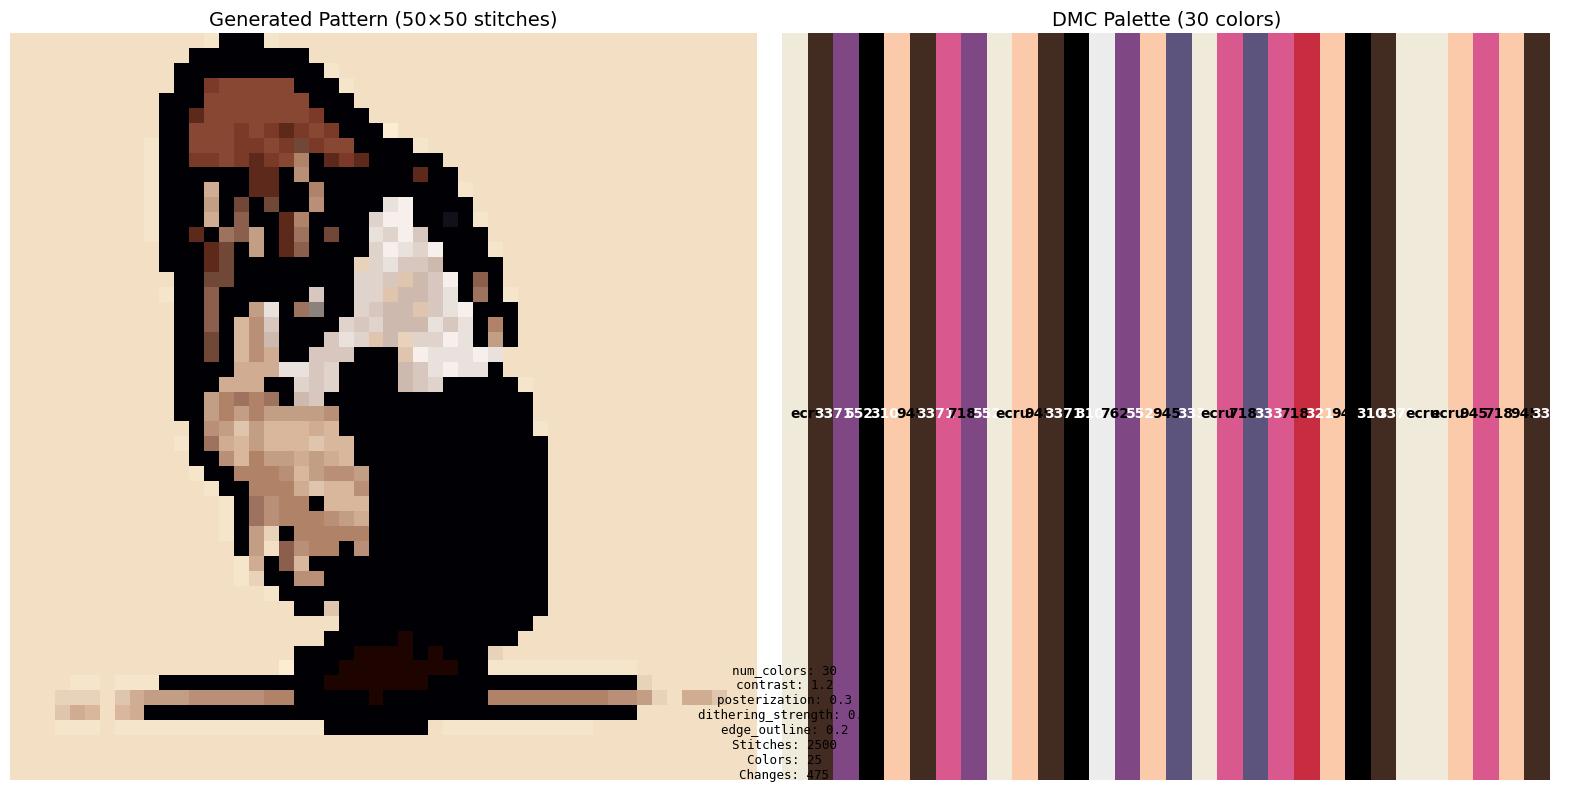

In [131]:
# Load one of your 20 images
test_params = {
       'num_colors': 30,
       'contrast': 1.2,
       'posterization': 0.3,
       'dithering_strength': 0.5,
       'edge_outline': 0.2
   }
# Single pattern - nice and large
result = generate_pattern('data/1.png', test_params)
visualize_pattern(result, show_grid=True)  # With stitch grid
visualize_pattern(result, upscale_factor=15)  # 750×750 pixels
visualize_pattern(result, upscale_factor=20)  # 1000×1000 pixels


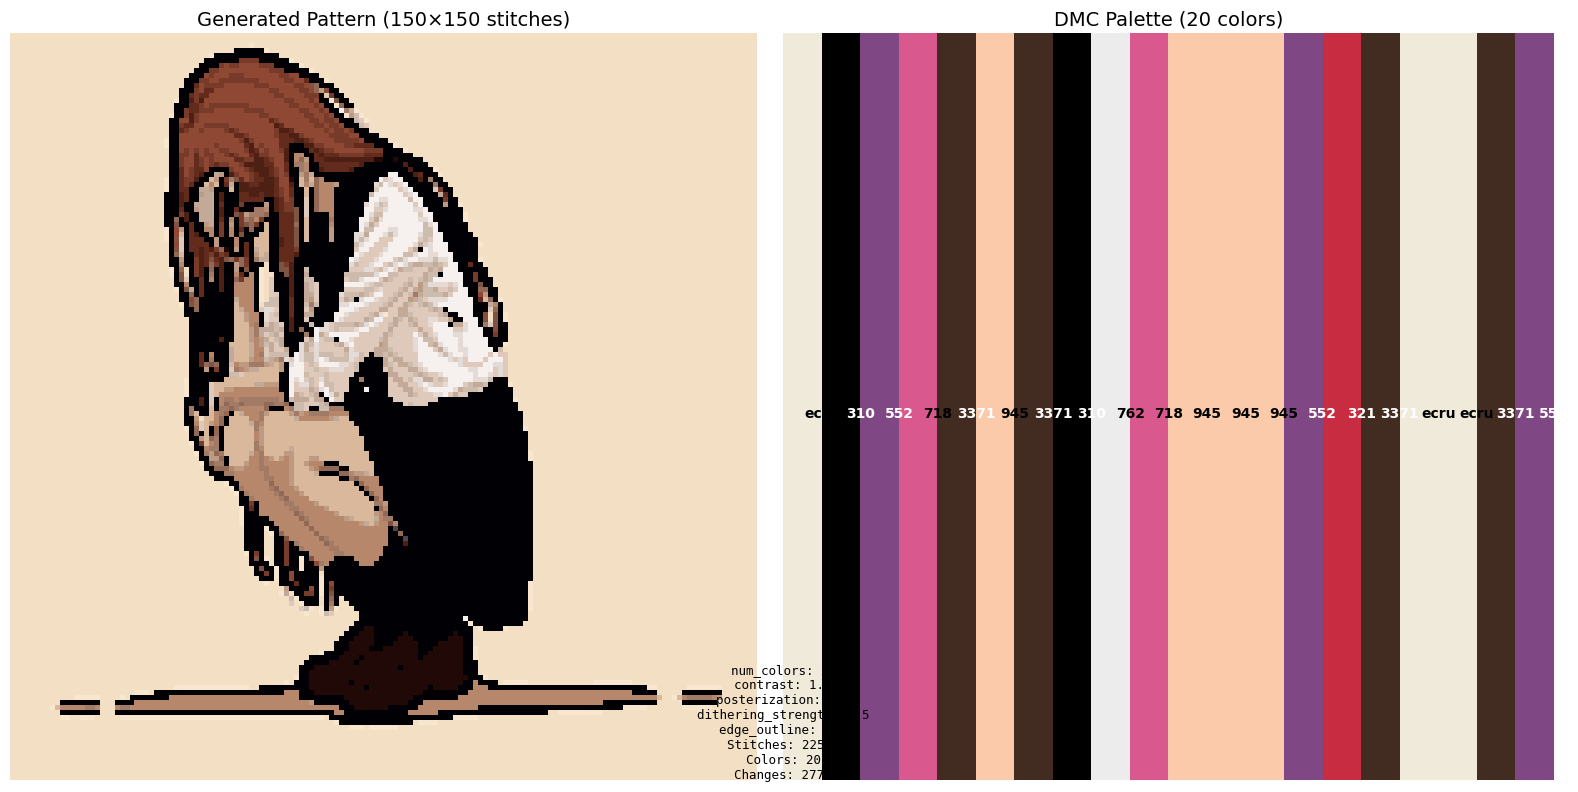

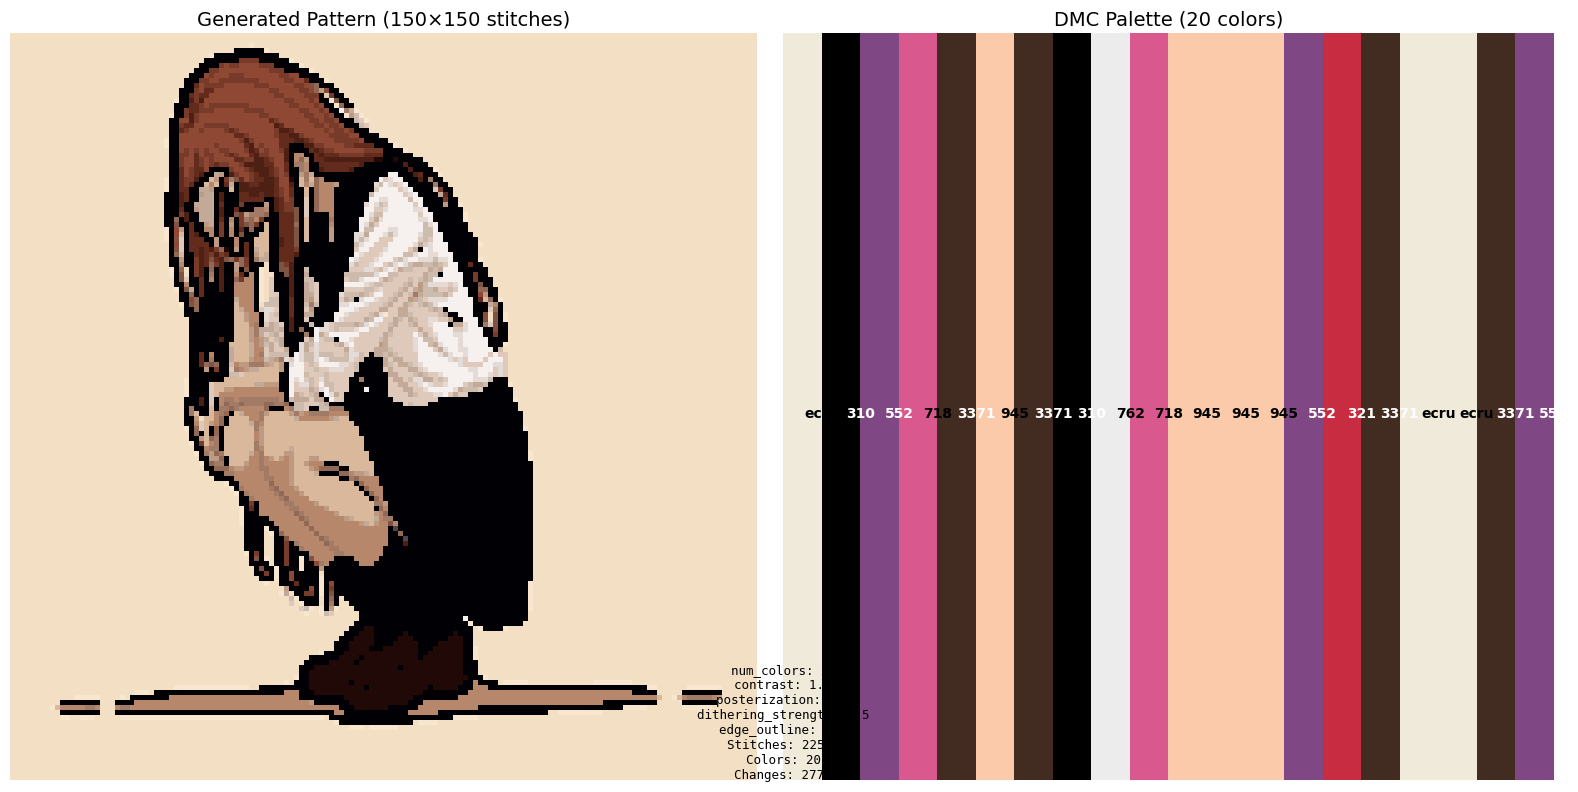

In [132]:
# Change grid_size to make a bigger pattern
test_params = {
    'num_colors': 20,
    'contrast': 1.2,
    'posterization': 0.3,
    'dithering_strength': 0.5,
    'edge_outline': 0.2
}

# Try 100×100 stitches instead
result = generate_pattern('data/1.png', test_params, grid_size=150)
visualize_pattern(result, upscale_factor=8)  # Display at 800×800 pixels

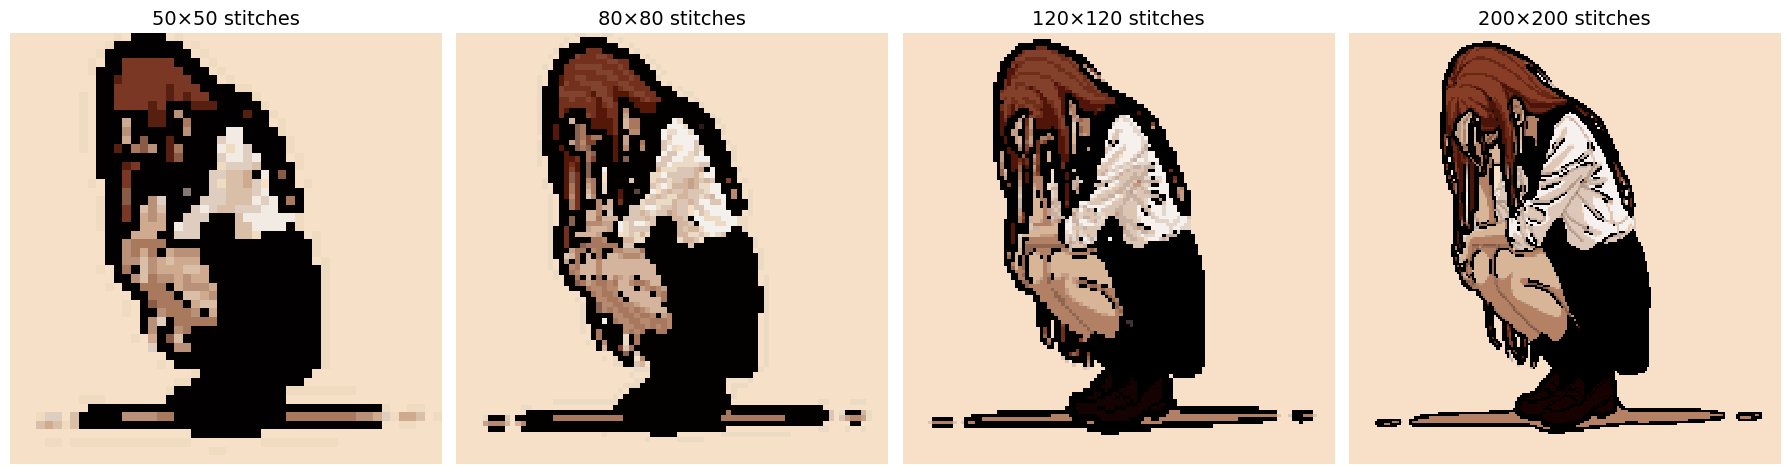

In [133]:
test_params = {
    'num_colors': 15,
    'contrast': 1.3,
    'posterization': 0.5,
    'dithering_strength': 0.3,
    'edge_outline': 0.3
}

# Compare different grid sizes
fig, axes = plt.subplots(1, 4, figsize=(18, 6))

for idx, size in enumerate([50, 80, 120, 200]):
    result = generate_pattern('data/1.png', test_params, grid_size=size)
    upscaled = np.repeat(np.repeat(result['pattern'], 5, axis=0), 5, axis=1)
    axes[idx].imshow(upscaled, interpolation='nearest')
    axes[idx].set_title(f'{size}×{size} stitches', fontsize=14)
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

Generating 150 pattern variations in 12×13 grid...
Progress: 0/150 variations...
Progress: 30/150 variations...
Progress: 60/150 variations...
Progress: 90/150 variations...
Progress: 120/150 variations...
✓ Generated all 150 variations!


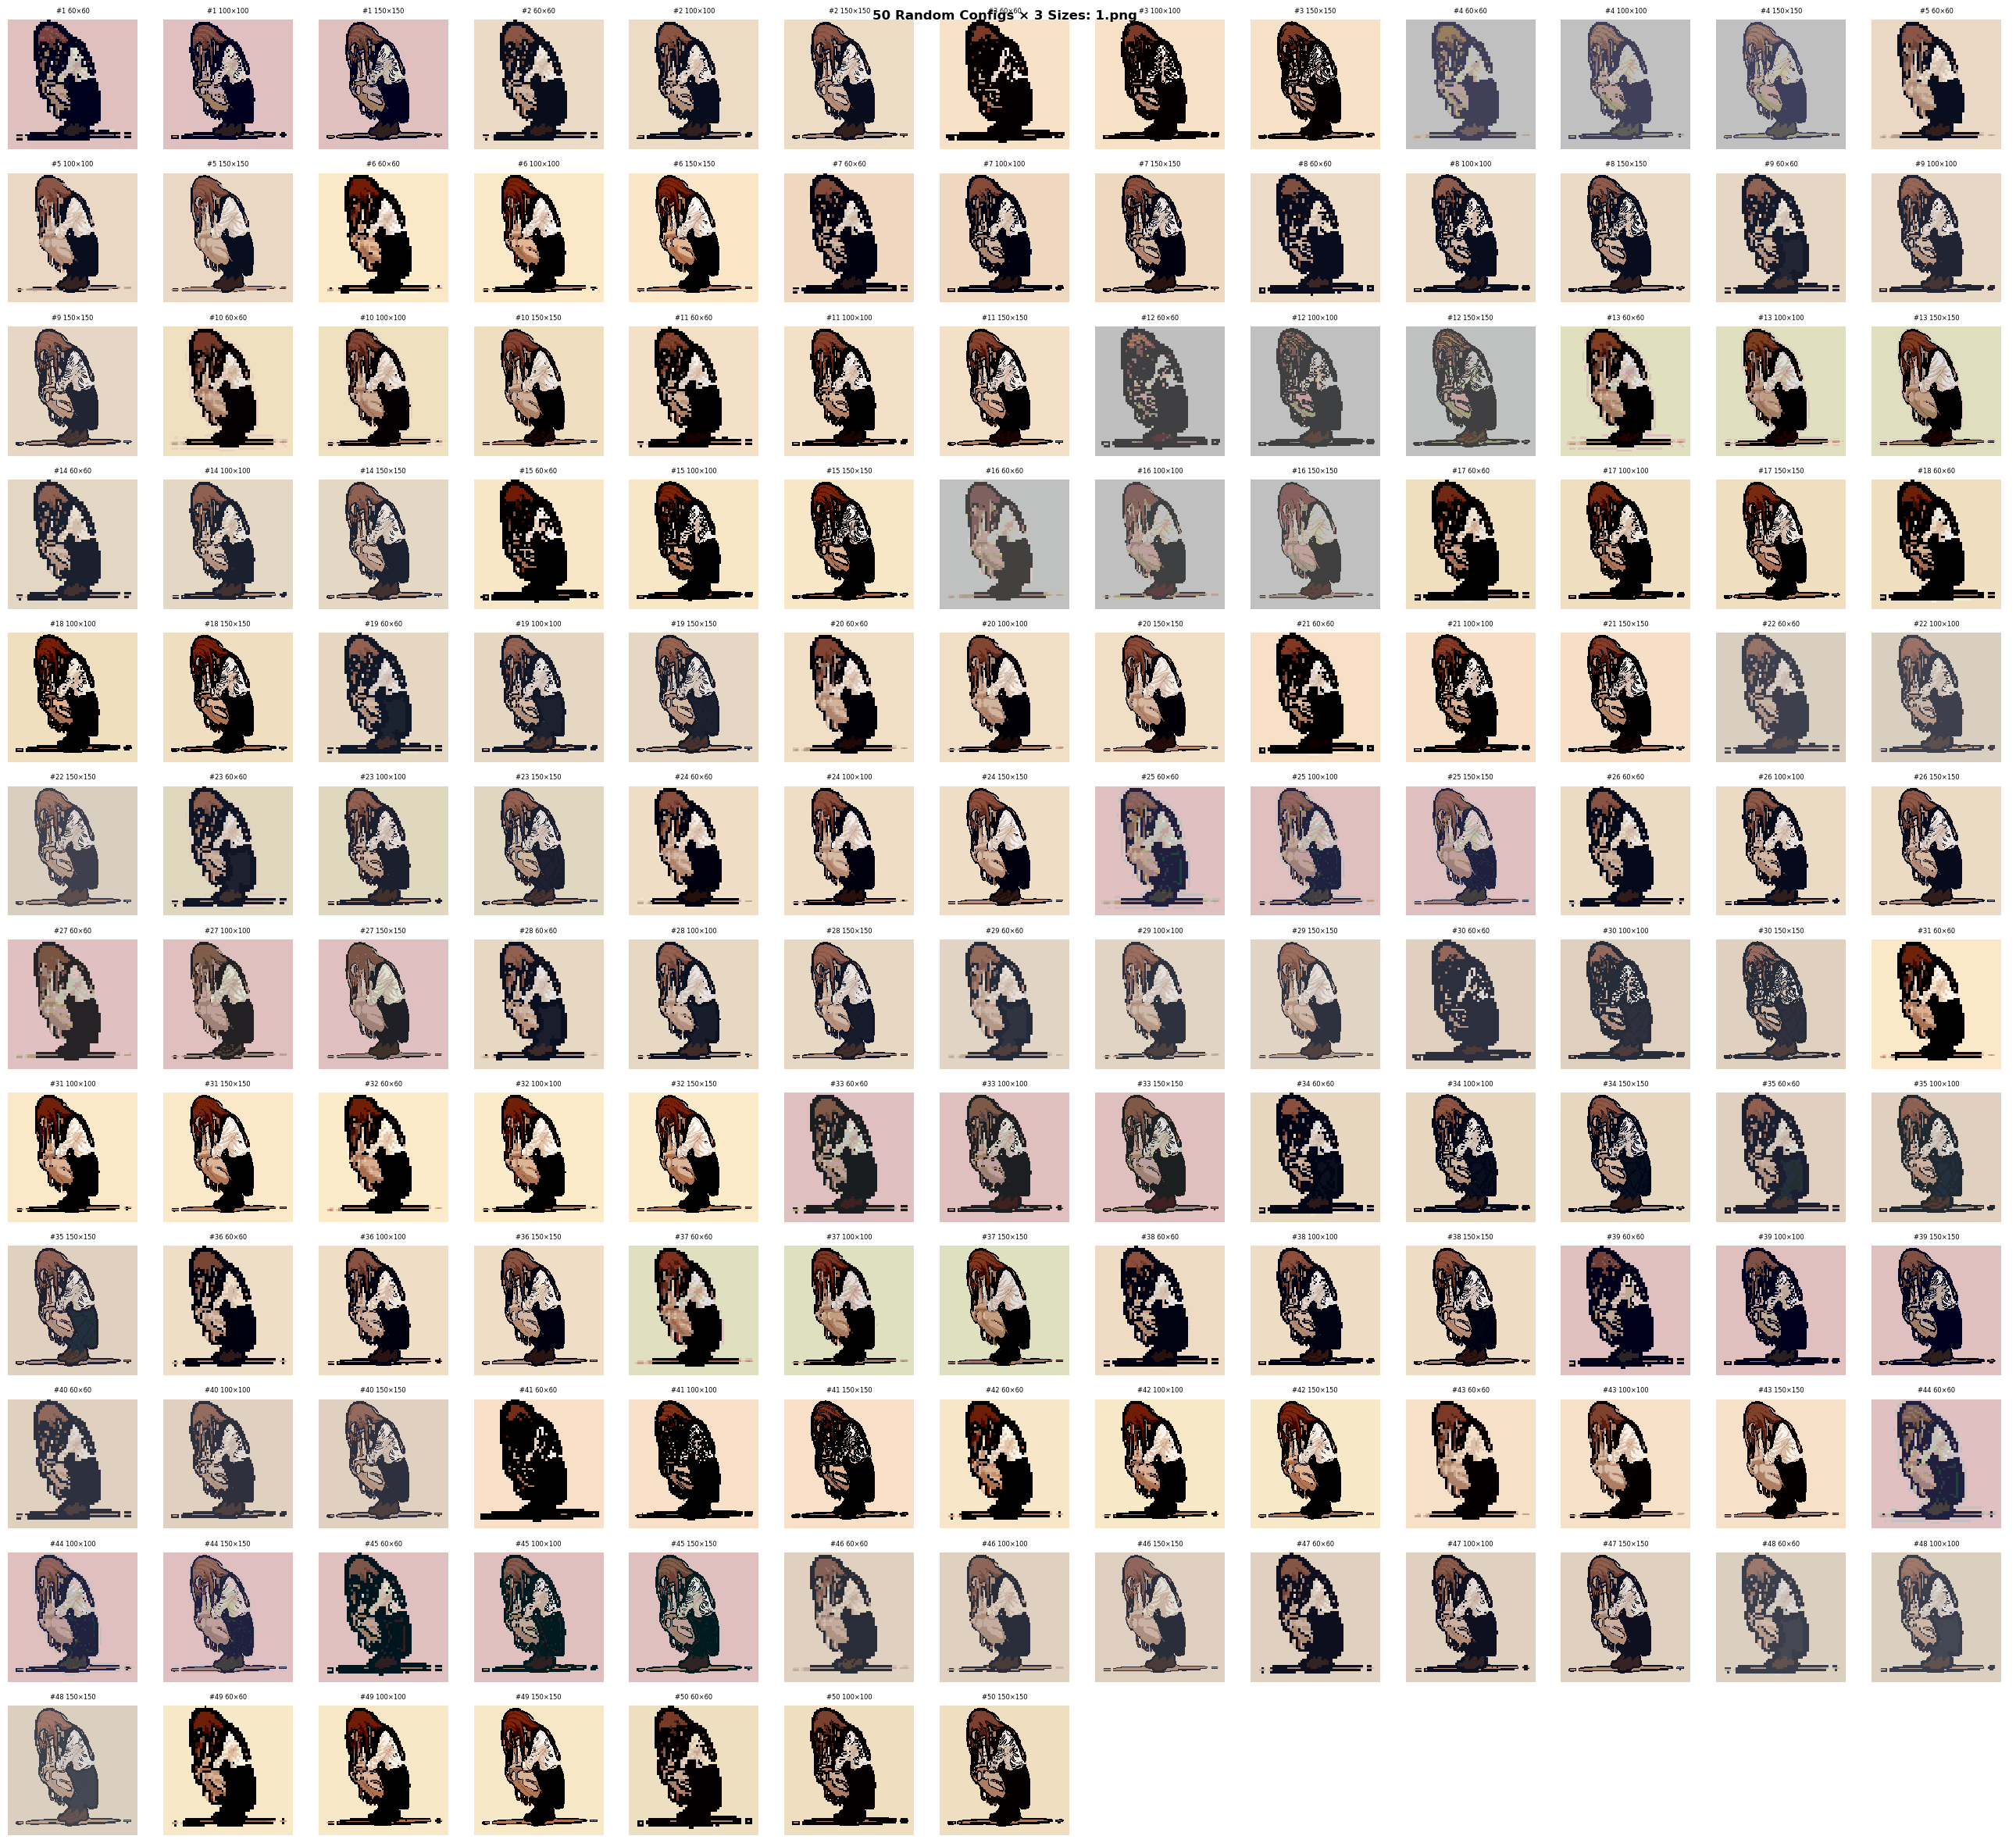

In [ ]:
# More compact - easier to scan visually
fig, param_configs = exhaustive_comparison_compact('data/1.png',
                                                   grid_sizes=[60, 100, 150],
                                                   n_param_samples=50)
plt.show()

# Save it
fig.savefig('all_variations_compact.png', dpi=150, bbox_inches='tight')

Generating 150 pattern variations in 12×13 grid...
Progress: 0/150 variations...
Progress: 30/150 variations...
Progress: 60/150 variations...
Progress: 90/150 variations...
Progress: 120/150 variations...
✓ Generated all 150 variations!


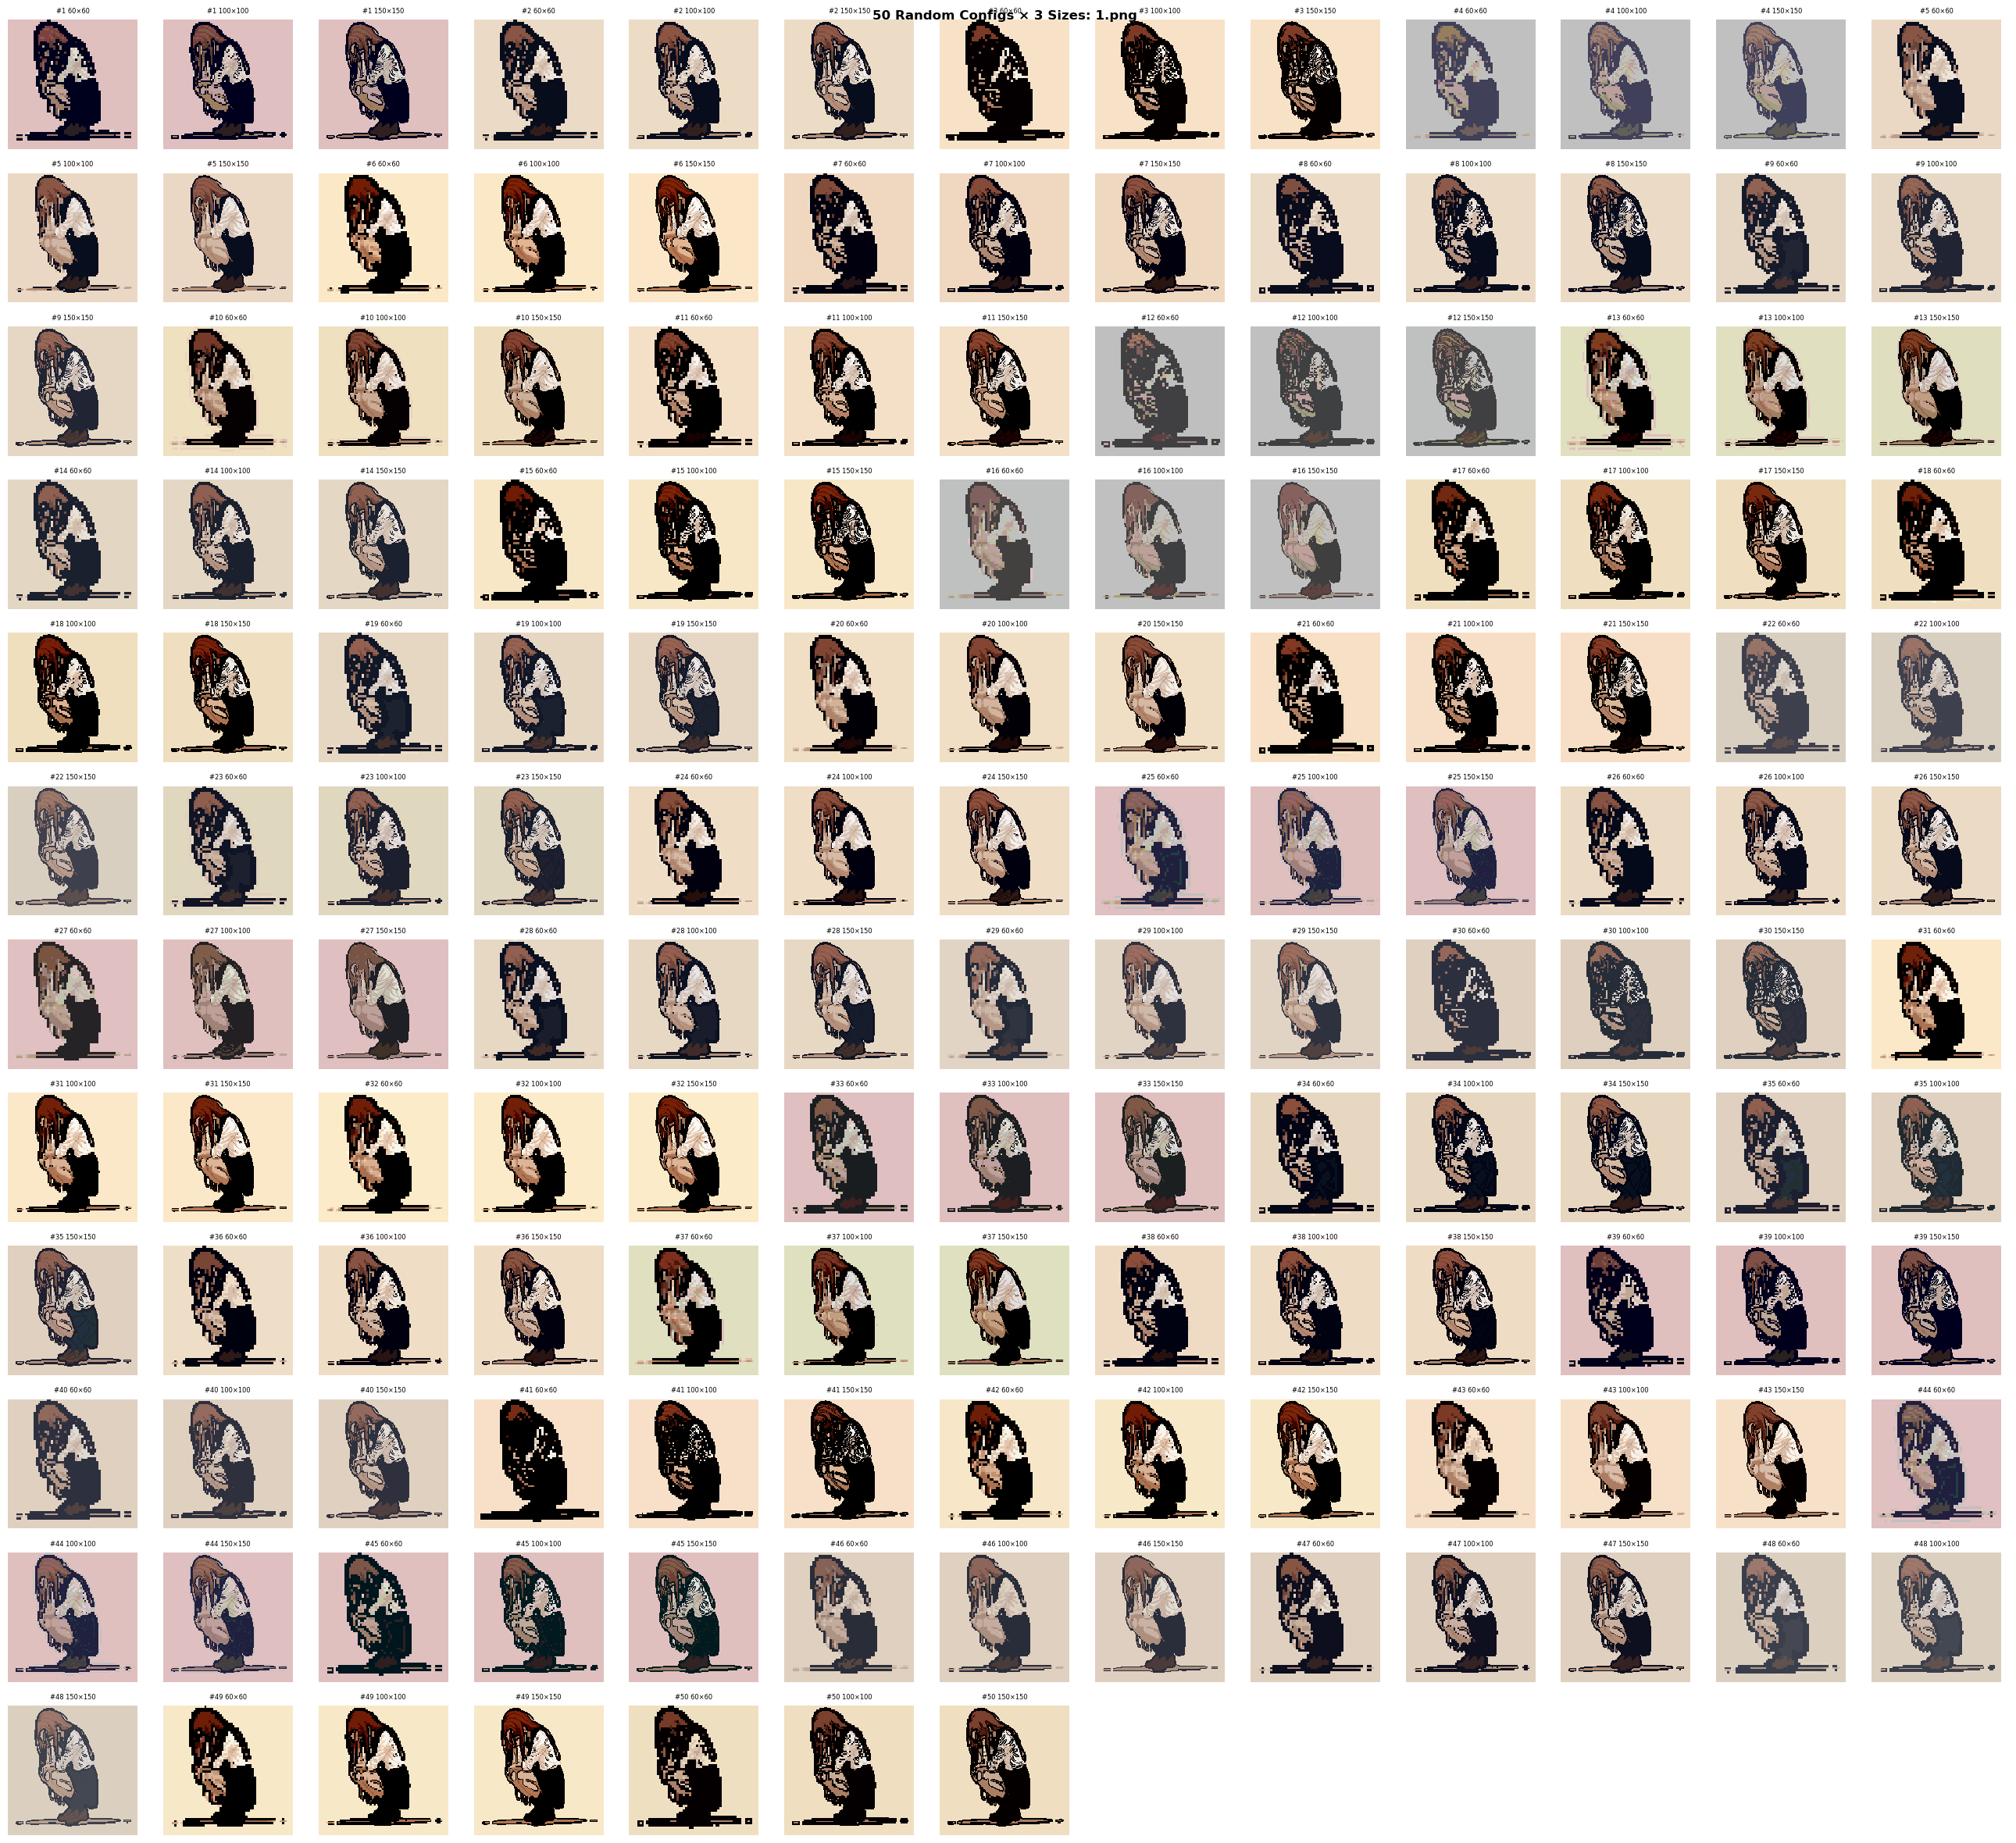

In [136]:
# When you generated the patterns, you should have done:
fig, configs = exhaustive_comparison_compact('data/1.png',
                                            grid_sizes=[60, 100, 150],
                                            n_param_samples=50)

# Now configs exists and you can use it:
favorites = [
    (5, 100),   # Config 5 at 100×100
    (12, 150),  # Config 12 at 150×150
    (23, 100),  # etc.
]

favorite_params = []
for config_num, size in favorites:
    favorite_params.append({
        'config': configs[config_num-1],
        'grid_size': size
    })

# Save them
import json
with open('my_favorites.json', 'w') as f:
    json.dump(favorite_params, f, indent=2)

Generating 150 pattern variations in 12×13 grid...
Progress: 0/150 variations...
Progress: 30/150 variations...
Progress: 60/150 variations...


/Users/poojasaji/miniforge3/envs/crossstitch/lib/python3.10/site-packages/sklearn/base.py:1365: ConvergenceWarning: Number of distinct clusters (17) found smaller than n_clusters (18). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Progress: 90/150 variations...
Progress: 120/150 variations...
✓ Generated all 150 variations!


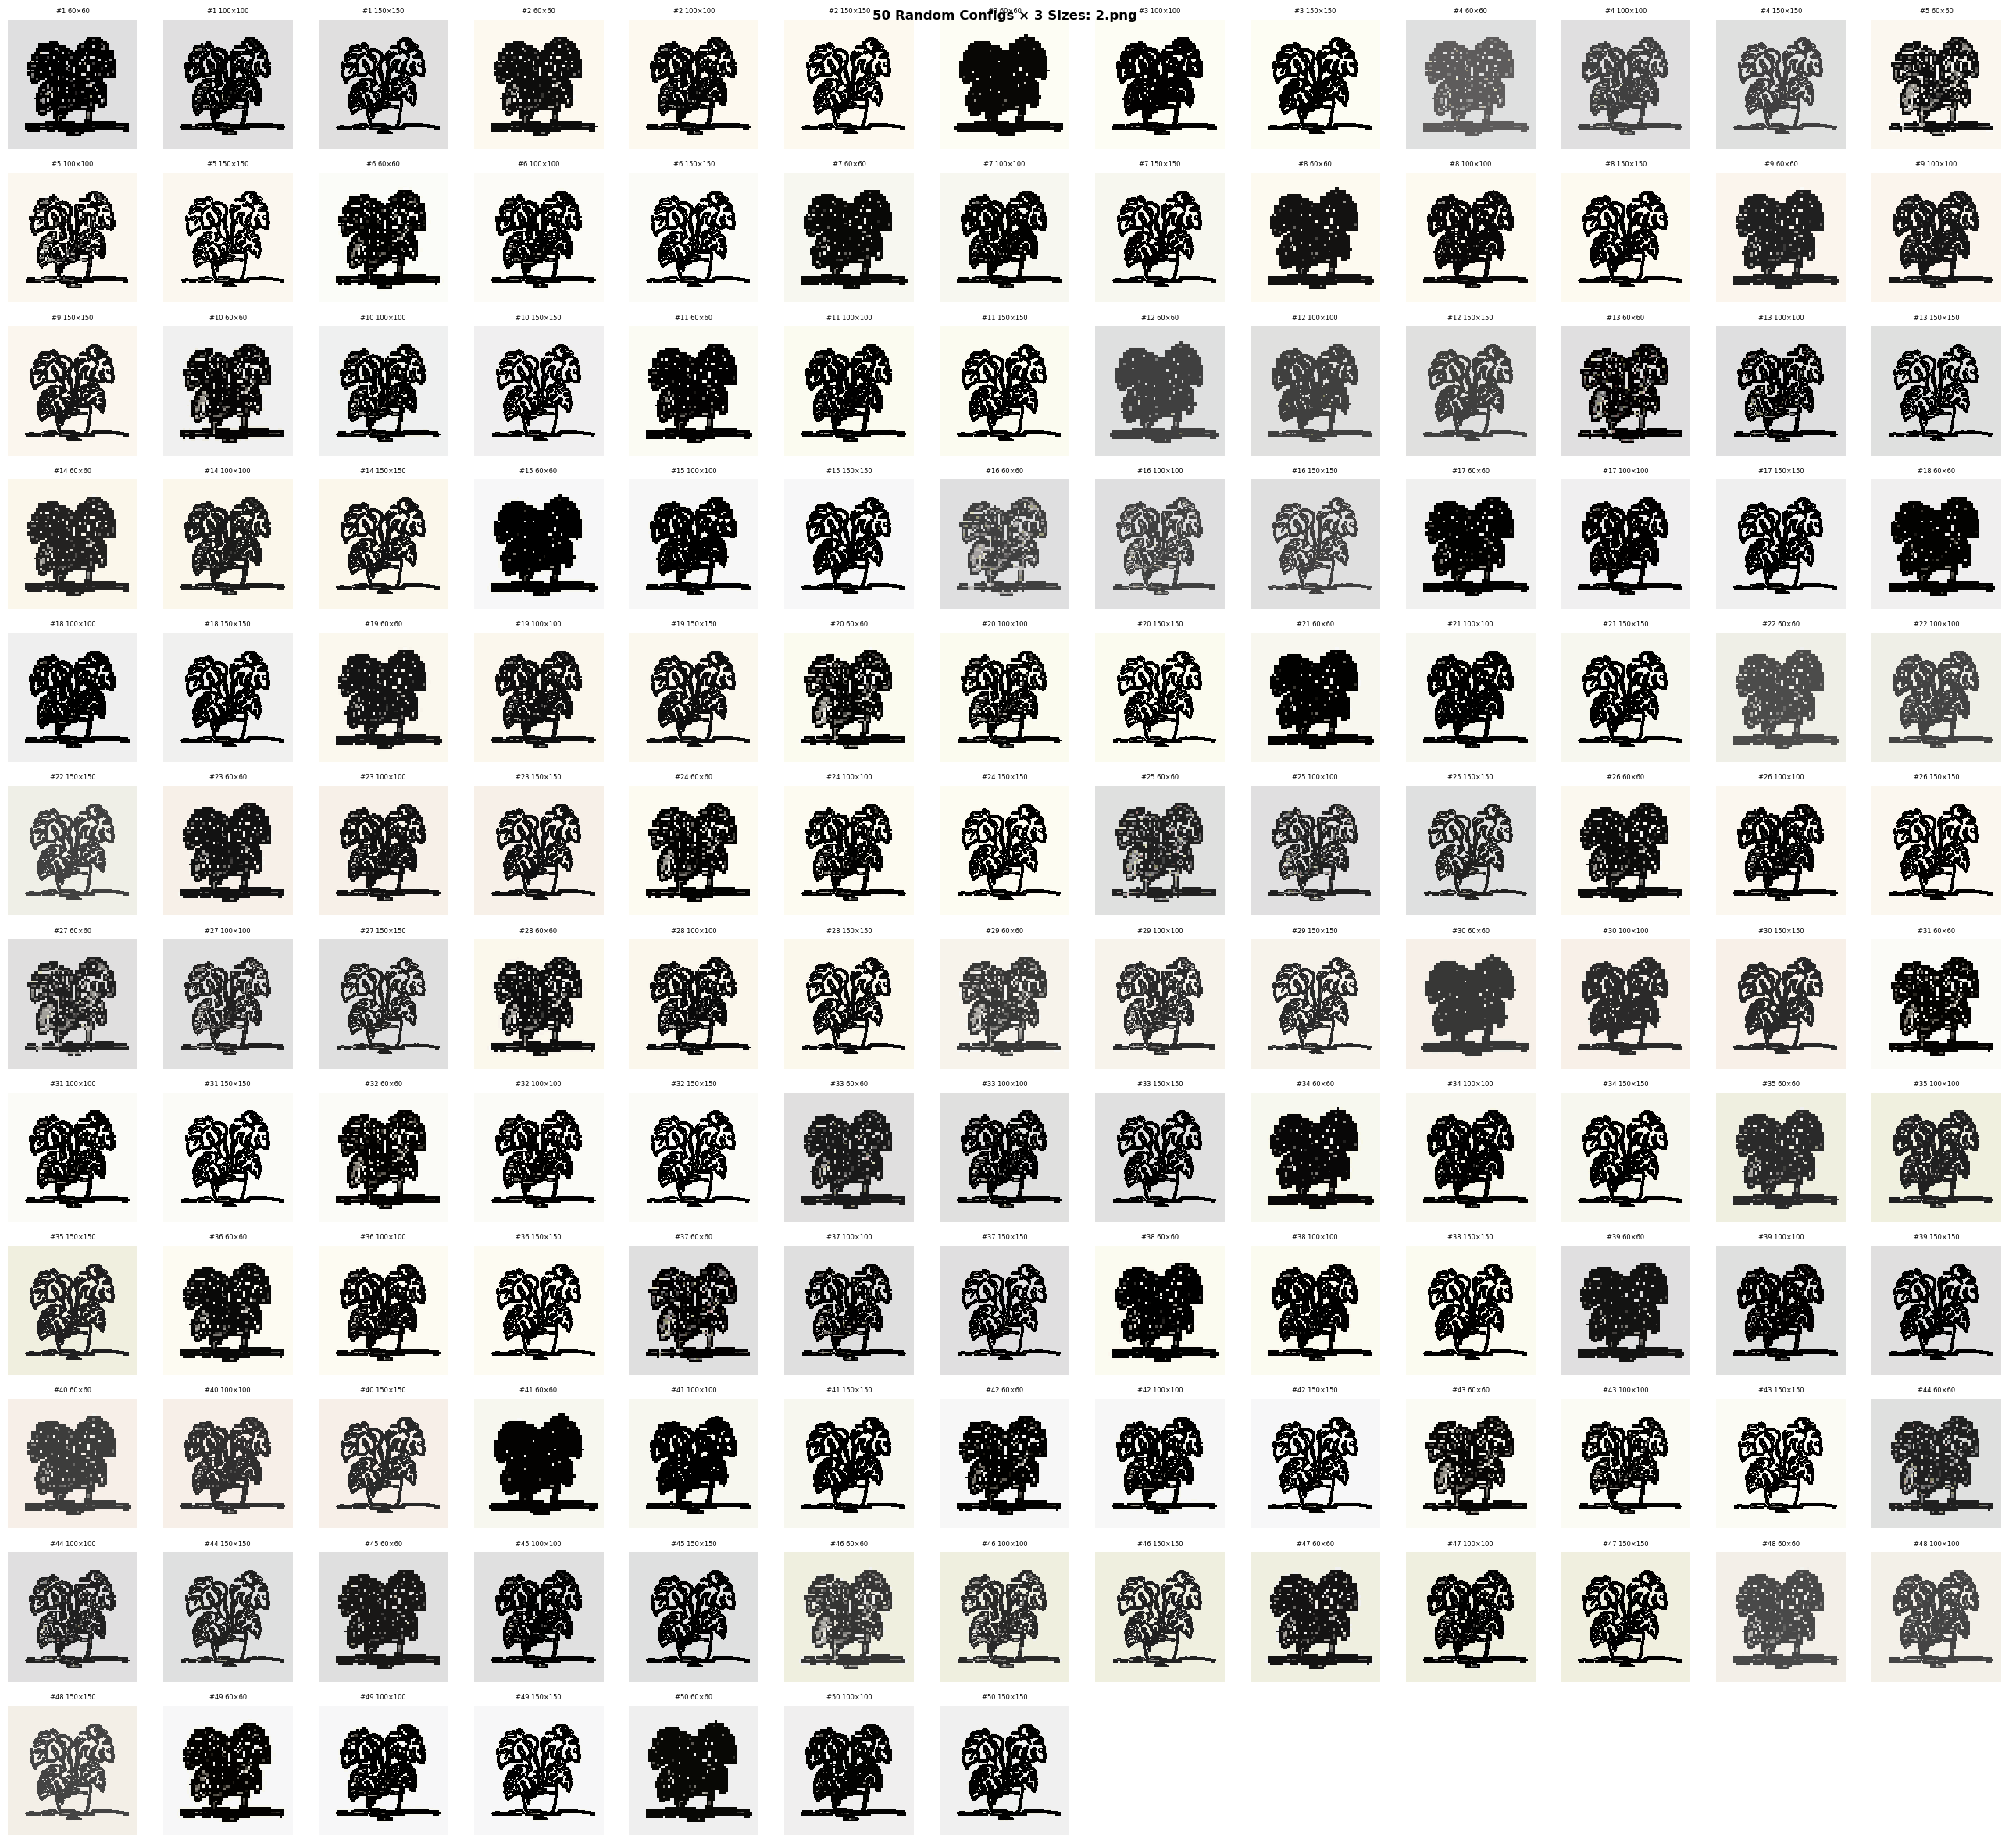

In [137]:
# When you generated the patterns, you should have done:
fig, configs = exhaustive_comparison_compact('data/2.png',
                                            grid_sizes=[60, 100, 150],
                                            n_param_samples=50)

# Now configs exists and you can use it:
favorites = [
    (5, 100),   # Config 5 at 100×100
    (12, 150),  # Config 12 at 150×150
    (23, 100),  # etc.
]

favorite_params = []
for config_num, size in favorites:
    favorite_params.append({
        'config': configs[config_num-1],
        'grid_size': size
    })

# Save them
import json
with open('my_favorites.json', 'w') as f:
    json.dump(favorite_params, f, indent=2)